# Infrrd task

# EDA

In [322]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re 
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

In [323]:
# creating empty dataframe 
df = pd.DataFrame() 

In [324]:
directory_path = 'C:/Users/choug/OneDrive/Desktop/Infrrd task/dataset/dataset/train/boxes_transcripts_labels'
tsv_files = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith(".tsv")]

In [325]:
# Iterating through the TSV files and concatenate them while adding a "Document No" column
for doc_no, tsv_file in enumerate(tsv_files, start=1):
    data = pd.read_csv(tsv_file, header=None)
    data["Document No"] = doc_no  # Adding a new column with the document number
    df = pd.concat([df, data], ignore_index=True)

In [326]:
df.head()

,0,1,2,3,4,5,6,7,Document No
0,33,33,215,4,227,21,a,OTHER,1
1,35,44,235,3,308,21,Employee's,OTHER,1
2,46,51,311,3,349,20,social,OTHER,1
3,53,60,352,3,401,20,security,OTHER,1
4,62,67,404,3,457,21,number,OTHER,1


In [327]:
df = df.dropna()
df.reset_index(drop=True, inplace=True)

In [328]:
df.shape

(237558, 9)

In [329]:
# assigning column names to dataframe
df.columns = ["start_index","end_index", "x_top_left", "y_top_left", "x_bottom_right", "y_bottom_right", "transcript", "field","Document No"]

In [330]:
# creating list of unique fields
unique_fields = df['field'].unique()
print(unique_fields)

['OTHER' 'ssnOfEmployee' 'einEmployerIdentificationNumber'
 'box1WagesTipsAndOtherCompensations' 'box2FederalIncomeTaxWithheld'
 'employerName' 'box3SocialSecurityWages' 'box4SocialSecurityTaxWithheld'
 'employerAddressStreet_name' 'employerAddressZip' 'employerAddressCity'
 'employerAddressState' 'employeeName' 'taxYear' 'box16StateWagesTips'
 'box17StateIncomeTax']


In [331]:
print(len(unique_fields))

16


In [332]:
# calculating counts of each class
value_counts = df['field'].value_counts()
value_counts

OTHER                                 222490
employerAddressStreet_name              2260
employerName                            1954
employeeName                            1123
box2FederalIncomeTaxWithheld            1106
box1WagesTipsAndOtherCompensations      1043
box16StateWagesTips                     1043
box17StateIncomeTax                     1023
box4SocialSecurityTaxWithheld           1009
box3SocialSecurityWages                  979
employerAddressCity                      840
employerAddressZip                       572
employerAddressState                     552
taxYear                                  546
einEmployerIdentificationNumber          542
ssnOfEmployee                            476
Name: field, dtype: int64

In [375]:
# calculating percenntage of values of each class
# Dataset is highly imbalanced

print(value_counts*100/df.shape[0])

OTHER                                 93.657128
employerAddressStreet_name             0.951347
employerName                           0.822536
employeeName                           0.472727
box2FederalIncomeTaxWithheld           0.465571
box1WagesTipsAndOtherCompensations     0.439051
box16StateWagesTips                    0.439051
box17StateIncomeTax                    0.430632
box4SocialSecurityTaxWithheld          0.424738
box3SocialSecurityWages                0.412110
employerAddressCity                    0.353598
employerAddressZip                     0.240783
employerAddressState                   0.232364
taxYear                                0.229839
einEmployerIdentificationNumber        0.228155
ssnOfEmployee                          0.200372
Name: field, dtype: float64


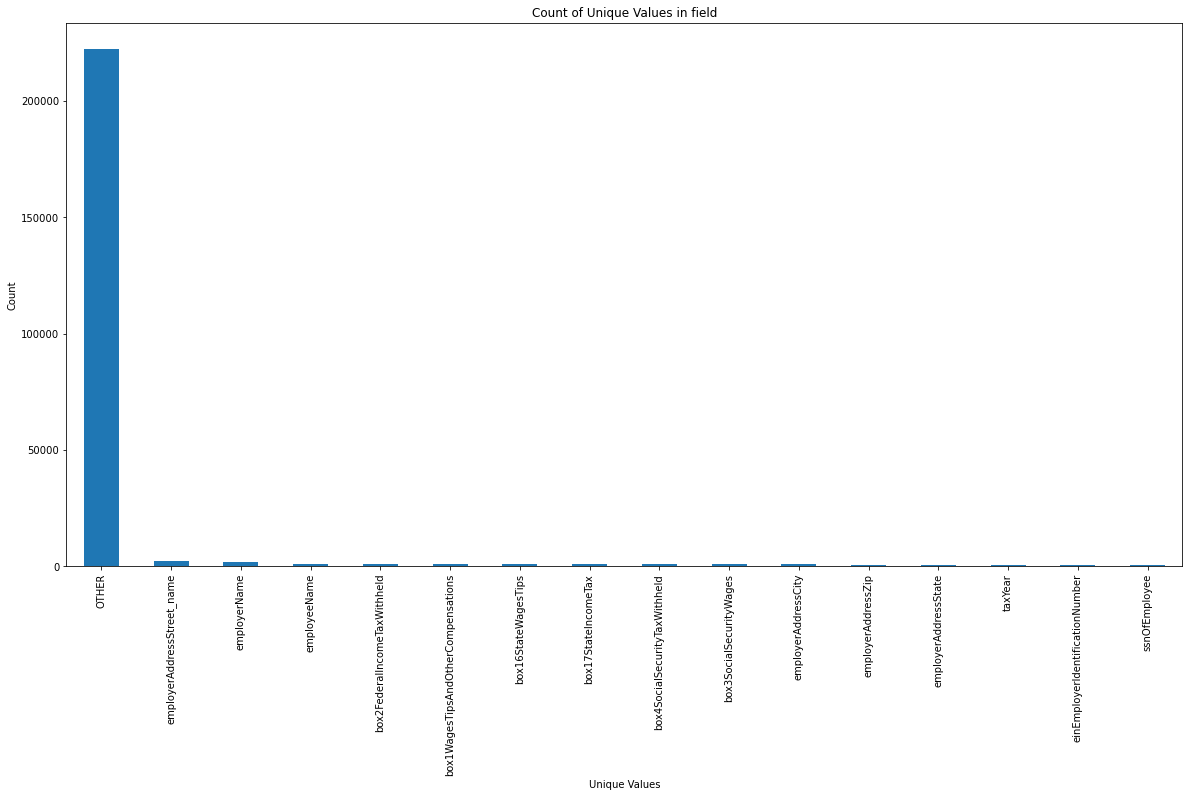

In [334]:
# Plotting bar graph
plt.figure(figsize=(20, 10))
value_counts.plot(kind='bar')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Count of Unique Values in field')
plt.show()

In [335]:
# checking the number of unique values in transcript column 
unique_transcript = df['transcript'].unique()
print(len(unique_transcript))

20182


# Feature Engineering

In [336]:
# this function maps the transcript to 0 or 1 ,if the input text contains any alphabet then it is 0 ,else it is 1
def label_rows(text):
    if not any(char.isalpha() for char in text):
        return 1
    else:
        return 0

In [337]:
def clean(text):
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Remove any character that is not alphabet or digit
    cleaned_text = re.sub(r'\b(?<!\w)\w\b', lambda x: x.group() + 'b', cleaned_text)
    #the above line adds the letter b to anythign which is a single character , this is done because tf idf was giving error for single chars
    cleaned_text = cleaned_text.lower() # convert into lowercase
    return cleaned_text

In [338]:
"""the data contained multiple documents where again in a single document the data had
multiple rows with transcript due to which tf idf would be inappropriate as every row is treated as seperate document
so we try to create a dataframe hich combined the trabscript of indvidual documents to applt tf-idf"""

# creates a dataframe where the transcripts of every transcript from its respective document are conacatenated
grouped = df.groupby("Document No")["transcript"].apply(lambda x: ' '.join(map(str, x))).reset_index()

In [339]:
grouped # here the rows 1 is concatenation of all the transcripts present in the an individual tsv file

,Document No,transcript
0,1,"a Employee's social security number Safe, Accu..."
1,2,12a being This information compensation Visit ...
2,3,Service. compensation Medicare 181 Treasury--I...
3,4,"This compensation 12a number Safe, Accurate, i..."
4,5,$35-36-3912 Ce . file 49239.09 10471-76 French...
...,...,...
595,596,"88314-7714 Wages, tips, other comp. 2 Federal ..."
596,597,"Employer's Wages, tips, other comp. 187638.77 ..."
597,598,12a 2 Federal income tax 34142 withheld . 49 1...
598,599,"234196.1 49-95-016 Wages, tips, other comp. 2 ..."


In [340]:
grouped['cleaned_transcript'] = grouped['transcript'].apply(clean) # preprocessing text so that tf-idf doesnt give error

In [341]:
grouped

,Document No,transcript,cleaned_transcript
0,1,"a Employee's social security number Safe, Accu...",ab employees social security number safe accur...
1,2,12a being This information compensation Visit ...,12a being this information compensation visit ...
2,3,Service. compensation Medicare 181 Treasury--I...,service compensation medicare 181 treasuryinte...
3,4,"This compensation 12a number Safe, Accurate, i...",this compensation 12a number safe accurate ins...
4,5,$35-36-3912 Ce . file 49239.09 10471-76 French...,35363912 ce file 4923909 1047176 french 104 a...
...,...,...,...
595,596,"88314-7714 Wages, tips, other comp. 2 Federal ...",883147714 wages tips other comp 2b federal inc...
596,597,"Employer's Wages, tips, other comp. 187638.77 ...",employers wages tips other comp 18763877 2b fe...
597,598,12a 2 Federal income tax 34142 withheld . 49 1...,12a 2b federal income tax 34142 withheld 49 1...
598,599,"234196.1 49-95-016 Wages, tips, other comp. 2 ...",2341961 4995016 wages tips other comp 2b feder...


In [342]:
tfidf_vectorizer = TfidfVectorizer(min_df=1,stop_words= None) # create vectoorizer object
tfidf_matrix = tfidf_vectorizer.fit_transform(grouped["cleaned_transcript"]) # fit on data
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out()) # create new df
tfidf_df["Document No"] = grouped["Document No"] # add document number column 
# the matrix represent the td-idf value for a particular word in a particular document
tfidf_df

,00,000,0000,00007012,000684,0008,00084,0009,001,00136,...,zes,zhang,zhangburgh,zhanghayes,zicks,zif,zik,zions,zip,Document No
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033018,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045146,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033123,3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042722,4
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046156,596
596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047193,597
597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045974,598
598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047710,599


In [343]:
# function to return tf-idf value
def tf_idf_value(word,docno):
    return tfidf_df[word][docno - 1]

In [344]:
print(tf_idf_value("zip",1))
print(tfidf_vectorizer.vocabulary_["zip"])

0.0330183033637355
17901


In [345]:
print(tfidf_matrix) 
# the output in the first row represent tf-idf value of word with word index 13783 in the document index 0 (document no 1)

  (0, 13783)	0.02374113080961959
  (0, 16942)	0.060875703281958585
  (0, 1578)	0.06479364639384515
  (0, 3908)	0.06479364639384515
  (0, 6560)	0.054177935293315854
  (0, 86)	0.032090836077860466
  (0, 12984)	0.05809587840520241
  (0, 8710)	0.06479364639384515
  (0, 7358)	0.06479364639384515
  (0, 16152)	0.03408463132738765
  (0, 15879)	0.05268840245277184
  (0, 14588)	0.06479364639384515
  (0, 17119)	0.06479364639384515
  (0, 14129)	0.05809587840520241
  (0, 17542)	0.06479364639384515
  (0, 16408)	0.0473447117622406
  (0, 14657)	0.025393068089217728
  (0, 8734)	0.06479364639384515
  (0, 1005)	0.06479364639384515
  (0, 16601)	0.01779669246213511
  (0, 17396)	0.06479364639384515
  (0, 6292)	0.05139811041655968
  (0, 14003)	0.04470034242791694
  (0, 13556)	0.06479364639384515
  (0, 5127)	0.04670672769442034
  :	:
  (599, 14226)	0.07062862162647783
  (599, 17901)	0.04716484711958831
  (599, 13647)	0.08281701374456005
  (599, 13538)	0.04708574775098522
  (599, 16305)	0.07015627896762214
  (

In [346]:
print(tfidf_vectorizer.vocabulary_) # words recognised by td-idf , anything outside this will give error

{'ab': 13510, 'employees': 14635, 'social': 17142, 'security': 17031, 'number': 16430, 'safe': 16941, 'accurate': 13516, 'visit': 17626, 'the': 17381, 'irs': 15428, 'website': 17714, '720749502': 10876, 'omb': 16490, 'no': 16379, '15450008': 2509, 'fast': 14766, 'use': 17566, 'se': 17015, 'file': 14825, 'at': 13747, 'wwwirsgovefile': 17858, 'bb': 13826, 'employer': 14638, 'identification': 15309, 'ein': 14573, 'wages': 17647, 'tips': 17452, 'other': 16546, 'compensation': 14250, 'federal': 14782, 'income': 15355, 'tax': 17347, 'withheld': 17812, '373493491': 7120, '41669': 7659, '07': 316, '1118293': 976, 'cb': 14115, 'employers': 14639, 'name': 16305, 'address': 13538, 'and': 13647, 'zip': 17901, 'code': 14226, 'collinssaunders': 14238, 'sons': 17159, '53826': 8968, '13': 1700, '4117': 7585, '7b': 11682, '9652': 13176, 'scott': 17002, 'groves': 15076, 'apt': 13707, '116': 1146, '5b': 9623, 'medicare': 16107, '6b': 10657, '708381080': 10745, '34390': 6725, '45': 8010, '99732': 13472, '

In [347]:
df['clean_transcript'] = df['transcript'].apply(clean) # pre-processing

In [348]:
empty_transcript_rows = df[df['clean_transcript'] == ''] # checking row with empty string as they give error
empty_transcript_rows
# rows which are empty 

,start_index,end_index,x_top_left,y_top_left,x_bottom_right,y_bottom_right,transcript,field,Document No,clean_transcript
18,272,272,955,14,973,39,~,OTHER,1,
59,896,896,1045,132,1055,153,.,box4SocialSecurityTaxWithheld,1,
77,1155,1155,797,182,806,203,.,OTHER,1,
90,1494,1494,1121,233,1131,254,.,OTHER,1,
190,3750,3750,597,600,607,621,.,OTHER,1,
...,...,...,...,...,...,...,...,...,...,...
237435,926,926,181,456,187,468,.,OTHER,600,
237438,976,976,502,455,507,468,.,OTHER,600,
237462,1250,1250,440,578,449,591,[,OTHER,600,
237509,1808,1808,494,831,498,845,.,box16StateWagesTips,600,


In [349]:
special_char_pattern = r'^[!@,.\s]+$'

In [350]:
"""replacing empty string with "ab" as tf-idf gives error for empty string , the rows also  can be removed but 
the rows have important field information in it so i transformed it """ 

rows_to_replace = df['clean_transcript'] == "" # tells which rows have empty string
df.loc[rows_to_replace, 'clean_transcript'] = 'ab' # Replace the selected rows with "ab"

In [351]:
tf_idf_values = [] # creating empty list to stored tf-idf values of all elements
for index, row in df.iterrows():
    transcript = row['clean_transcript']
    document_no = row['Document No']
    tf_idf_values.append(tfidf_df[transcript][document_no-1])

In [352]:
df["tf_idf"] = tf_idf_values # adding tf-idf column to df

In [353]:
df['label'] = df['transcript'].apply(label_rows) #applying label rows fnc which assign 0 to transcript with alphabet , else 1 

In [354]:
df['len'] = df["transcript"].apply(len) # creates new column which tells length of transcript

In [355]:
# encoding output lables
label_encoder = LabelEncoder()
df['field_encoded'] = label_encoder.fit_transform(df['field'])

In [356]:
df

,start_index,end_index,x_top_left,y_top_left,x_bottom_right,y_bottom_right,transcript,field,Document No,clean_transcript,tf_idf,label,len,field_encoded
0,33,33,215,4,227,21,a,OTHER,1,ab,0.055216,0,1,0
1,35,44,235,3,308,21,Employee's,OTHER,1,employees,0.086007,0,10,0
2,46,51,311,3,349,20,social,OTHER,1,social,0.065705,0,6,0
3,53,60,352,3,401,20,security,OTHER,1,security,0.065815,0,8,0
4,62,67,404,3,457,21,number,OTHER,1,number,0.088049,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237553,2325,2327,365,1064,385,1079,Tax,OTHER,600,tax,0.153370,0,3,0
237554,2329,2334,388,1064,429,1079,Return,OTHER,600,return,0.025532,0,6,0
237555,2336,2338,451,1063,482,1078,OMB,OTHER,600,omb,0.026833,0,3,0
237556,2340,2342,485,1063,509,1078,No.,OTHER,600,no,0.048862,0,3,0


In [357]:
import spacy
nlp = spacy.load("en_core_web_sm")

ner_results = []

for index, row in grouped.iterrows():
    doc = nlp(row["cleaned_transcript"])
    word_ner_dict = {}
    
    for ent in doc.ents:
        word_ner_dict[ent.text] = ent.label_
    ner_results.append(word_ner_dict)

In [358]:

"""the output of the ner model is not good so it is not used for making new feature otherwise 
a new feature could be made by label encoding the named entitites"""
ner_results

[{'irs': 'ORG',
  '720749502': 'DATE',
  '373493491 41669': 'DATE',
  '07 1118293': 'DATE',
  '13': 'MONEY',
  '7b 9652 scott': 'QUANTITY',
  '116 5b': 'CARDINAL',
  'medicare': 'ORG',
  '6b': 'CARDINAL',
  '708381080 34390  ': 'DATE',
  '45 99732': 'DATE',
  '13 34390  ': 'DATE',
  '45': 'CARDINAL',
  'db': 'NORP',
  '10': 'CARDINAL',
  '8282622 24': 'CARDINAL',
  'first': 'ORDINAL',
  '11': 'CARDINAL',
  '12a': 'DATE',
  '12': 'CARDINAL',
  '293 bb': 'QUANTITY',
  '12b 2995': 'DATE',
  '403 east karenfort': 'LOC',
  '51736427': 'DATE',
  '490 15': 'CARDINAL',
  '16': 'CARDINAL',
  '17': 'CARDINAL',
  '18': 'CARDINAL',
  '19': 'CARDINAL',
  '20': 'CARDINAL',
  '39279132 20287': 'DATE',
  '85 1690': 'DATE',
  '44': 'CARDINAL',
  '47322': 'DATE',
  '75 5157': 'DATE',
  'joshua estates': 'PERSON',
  '94302332': 'DATE',
  '87 1267 97 34247': 'DATE',
  '05': 'CARDINAL',
  '472053': 'CARDINAL',
  '2019': 'DATE',
  '07 11182 93': 'DATE',
  'cb employers name': 'ORG',
  '3b': 'CARDINAL',
  '1

In [359]:
missing_values = df.isna().sum()
print(missing_values)

start_index         0
end_index           0
x_top_left          0
y_top_left          0
x_bottom_right      0
y_bottom_right      0
transcript          0
field               0
Document No         0
clean_transcript    0
tf_idf              0
label               0
len                 0
field_encoded       0
dtype: int64


In [360]:
df.drop_duplicates()
df.reset_index(drop=True, inplace=True)

In [361]:
df.shape

(237558, 14)

In [362]:
df

,start_index,end_index,x_top_left,y_top_left,x_bottom_right,y_bottom_right,transcript,field,Document No,clean_transcript,tf_idf,label,len,field_encoded
0,33,33,215,4,227,21,a,OTHER,1,ab,0.055216,0,1,0
1,35,44,235,3,308,21,Employee's,OTHER,1,employees,0.086007,0,10,0
2,46,51,311,3,349,20,social,OTHER,1,social,0.065705,0,6,0
3,53,60,352,3,401,20,security,OTHER,1,security,0.065815,0,8,0
4,62,67,404,3,457,21,number,OTHER,1,number,0.088049,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237553,2325,2327,365,1064,385,1079,Tax,OTHER,600,tax,0.153370,0,3,0
237554,2329,2334,388,1064,429,1079,Return,OTHER,600,return,0.025532,0,6,0
237555,2336,2338,451,1063,482,1078,OMB,OTHER,600,omb,0.026833,0,3,0
237556,2340,2342,485,1063,509,1078,No.,OTHER,600,no,0.048862,0,3,0


In [363]:
df.describe()

,start_index,end_index,x_top_left,y_top_left,x_bottom_right,y_bottom_right,Document No,tf_idf,label,len,field_encoded
count,237558.000000,237558.000000,237558.000000,237558.000000,237558.000000,237558.000000,237558.000000,237558.000000,237558.000000,237558.000000,237558.000000
mean,5866.570896,5870.334251,885.841112,1183.259452,939.037317,1209.707507,293.992166,0.071167,0.271601,4.785762,0.502736
std,4909.588481,4909.519821,614.092519,773.204461,616.440183,776.557540,173.331762,0.048846,0.444786,2.815753,2.206753
min,0.000000,0.000000,2.000000,1.000000,20.000000,18.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,1768.000000,1771.000000,346.000000,551.000000,398.000000,575.000000,137.000000,0.032443,0.000000,3.000000,0.000000
50%,4603.000000,4607.000000,816.000000,1046.000000,868.000000,1074.000000,299.000000,0.058922,0.000000,4.000000,0.000000
75%,9094.000000,9098.000000,1349.000000,1773.000000,1395.000000,1805.000000,443.000000,0.101645,1.000000,6.000000,0.000000
max,24646.000000,24654.000000,2395.000000,3070.000000,2458.000000,3103.000000,600.000000,0.804587,1.000000,22.000000,15.000000


<Figure size 864x576 with 0 Axes>

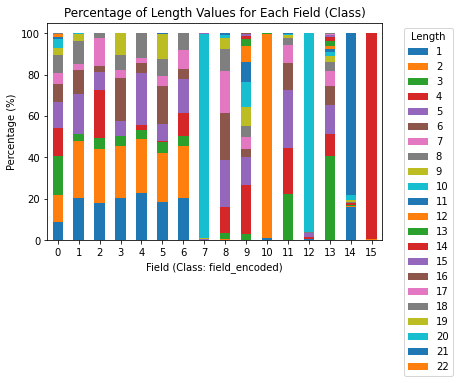

In [364]:

df1 = df[["field_encoded", "len"]]

# Calculating the count of each combination of class and length
count_by_combination = df1.groupby(["field_encoded", "len"]).size().unstack(fill_value=0)

# Calculating the total count of samples in each class
total_count_by_class = df1.groupby("field_encoded").size()

# Calculating the percentage of each length value within each class
result = count_by_combination.div(total_count_by_class, axis=0).mul(100)

# Plotting the percentages
plt.figure(figsize=(12, 8))
result.plot(kind='bar', stacked=True)
plt.xlabel("Field (Class: field_encoded)")
plt.ylabel("Percentage (%)")
plt.title("Percentage of Length Values for Each Field (Class)")
plt.legend(title="Length", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

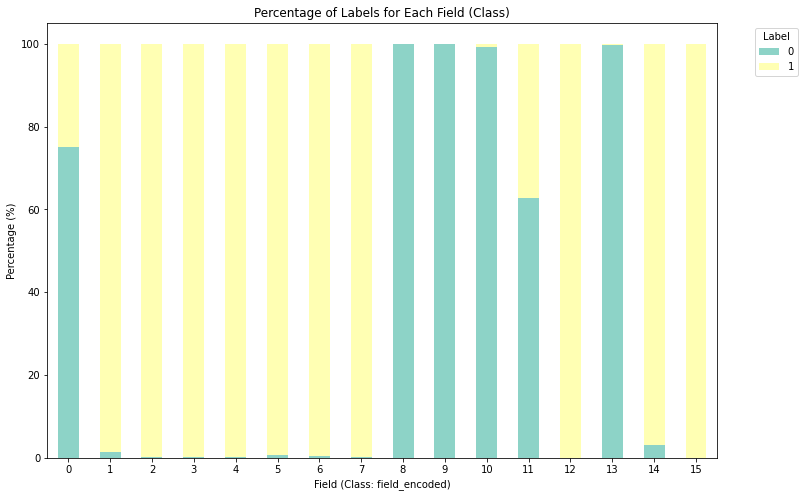

In [365]:
count_by_combination = df.groupby(["field_encoded", "label"]).size().unstack(fill_value=0)
total_count_by_field = df.groupby("field_encoded").size()
result = count_by_combination.div(total_count_by_field, axis=0) * 100
colors = plt.cm.Set3(range(len(result.columns)))
fig, ax = plt.subplots(figsize=(12, 8))
result.plot(kind='bar', stacked=True, color=colors, ax=ax)
ax.set_xlabel("Field (Class: field_encoded)")
ax.set_ylabel("Percentage (%)")
ax.set_title("Percentage of Labels for Each Field (Class)")
ax.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

In [366]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237558 entries, 0 to 237557
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   start_index       237558 non-null  int64  
 1   end_index         237558 non-null  int64  
 2   x_top_left        237558 non-null  int64  
 3   y_top_left        237558 non-null  int64  
 4   x_bottom_right    237558 non-null  int64  
 5   y_bottom_right    237558 non-null  int64  
 6   transcript        237558 non-null  object 
 7   field             237558 non-null  object 
 8   Document No       237558 non-null  int64  
 9   clean_transcript  237558 non-null  object 
 10  tf_idf            237558 non-null  float64
 11  label             237558 non-null  int64  
 12  len               237558 non-null  int64  
 13  field_encoded     237558 non-null  int32  
dtypes: float64(1), int32(1), int64(9), object(3)
memory usage: 24.5+ MB


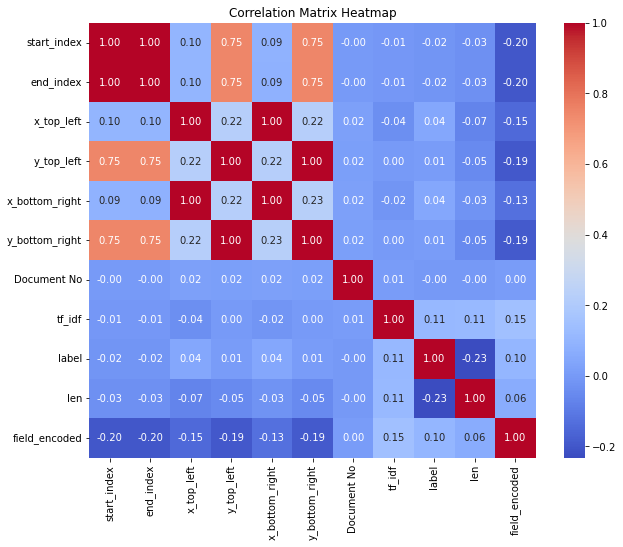

In [367]:
corr_matrix = df.corr() # gives correlation matrix
#plotting heatmap of correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [368]:
df

,start_index,end_index,x_top_left,y_top_left,x_bottom_right,y_bottom_right,transcript,field,Document No,clean_transcript,tf_idf,label,len,field_encoded
0,33,33,215,4,227,21,a,OTHER,1,ab,0.055216,0,1,0
1,35,44,235,3,308,21,Employee's,OTHER,1,employees,0.086007,0,10,0
2,46,51,311,3,349,20,social,OTHER,1,social,0.065705,0,6,0
3,53,60,352,3,401,20,security,OTHER,1,security,0.065815,0,8,0
4,62,67,404,3,457,21,number,OTHER,1,number,0.088049,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237553,2325,2327,365,1064,385,1079,Tax,OTHER,600,tax,0.153370,0,3,0
237554,2329,2334,388,1064,429,1079,Return,OTHER,600,return,0.025532,0,6,0
237555,2336,2338,451,1063,482,1078,OMB,OTHER,600,omb,0.026833,0,3,0
237556,2340,2342,485,1063,509,1078,No.,OTHER,600,no,0.048862,0,3,0


# Best model

In [243]:
X = df[['start_index','end_index','x_top_left','y_top_left','x_bottom_right','y_bottom_right','tf_idf','label','len']]

In [244]:
Y = df['field_encoded']

In [245]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y,test_size  = 0.2,random_state=42)

In [246]:
RFC  = RandomForestClassifier(n_estimators=300,random_state = 42)
RFC.fit(X_train,Y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

In [247]:
y_pred = RFC.predict(X_val)
class_report = classification_report(Y_val,y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     44476
           1       0.97      0.77      0.86       215
           2       0.95      0.84      0.89       183
           3       0.97      0.92      0.94       221
           4       1.00      0.94      0.96       219
           5       0.94      0.89      0.91       194
           6       0.98      0.90      0.94       203
           7       0.98      0.95      0.97       120
           8       0.97      0.84      0.90       218
           9       0.90      0.88      0.89       156
          10       0.98      0.89      0.93       114
          11       0.96      0.91      0.94       468
          12       0.98      0.95      0.97       136
          13       0.97      0.86      0.91       390
          14       0.99      0.96      0.97        90
          15       1.00      0.96      0.98       109

    accuracy                           0.99     47512
   macro avg       0.97   

In [248]:
# other trained models given below

# Model 1 - Decision tree - 3 features - imbalanced dataset 

In [249]:
# input features 
# initially trying only 3 features
X = df[['start_index', 'x_top_left', 'y_bottom_right']]

In [250]:
# output feature
Y = df["field_encoded"]

In [251]:
# 80-20 train val split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [252]:
classifier = DecisionTreeClassifier()  # You can choose any classifier
classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [253]:
y_pred = classifier.predict(X_val)
class_report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)
print(class_report)

                                    precision    recall  f1-score   support

                             OTHER       0.99      0.99      0.99     44476
               box16StateWagesTips       0.76      0.73      0.75       215
               box17StateIncomeTax       0.71      0.74      0.73       183
box1WagesTipsAndOtherCompensations       0.84      0.83      0.84       221
      box2FederalIncomeTaxWithheld       0.89      0.86      0.87       219
           box3SocialSecurityWages       0.85      0.81      0.83       194
     box4SocialSecurityTaxWithheld       0.83      0.85      0.84       203
   einEmployerIdentificationNumber       0.77      0.82      0.79       120
                      employeeName       0.76      0.76      0.76       218
               employerAddressCity       0.77      0.79      0.78       156
              employerAddressState       0.51      0.49      0.50       114
        employerAddressStreet_name       0.79      0.81      0.80       468
           

In [254]:
# the above scores are descent considering that the data is imbalanced and not even all features are used

# Model 2 - K Nearest Neighbours - 3 features - imbalanced dataset 

In [255]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [256]:
y_pred = knn.predict(X_val)
class_report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)
print(class_report)

                                    precision    recall  f1-score   support

                             OTHER       0.98      0.99      0.99     44476
               box16StateWagesTips       0.78      0.55      0.64       215
               box17StateIncomeTax       0.65      0.56      0.60       183
box1WagesTipsAndOtherCompensations       0.83      0.74      0.78       221
      box2FederalIncomeTaxWithheld       0.85      0.78      0.81       219
           box3SocialSecurityWages       0.87      0.71      0.78       194
     box4SocialSecurityTaxWithheld       0.85      0.77      0.81       203
   einEmployerIdentificationNumber       0.85      0.66      0.74       120
                      employeeName       0.78      0.62      0.69       218
               employerAddressCity       0.72      0.66      0.69       156
              employerAddressState       0.55      0.42      0.48       114
        employerAddressStreet_name       0.74      0.67      0.70       468
           

In [257]:
# knn is not good with imbalanced data

# Model 3 - Random Forest - 3 features - imbalanced dataset 

In [258]:
RFC = RandomForestClassifier(n_estimators=200, random_state=42)
RFC.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [259]:
y_pred = RFC.predict(X_val)
class_report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)
print(class_report)
# random forest is easily giving the best output

                                    precision    recall  f1-score   support

                             OTHER       0.99      1.00      0.99     44476
               box16StateWagesTips       0.94      0.70      0.80       215
               box17StateIncomeTax       0.95      0.69      0.80       183
box1WagesTipsAndOtherCompensations       0.95      0.82      0.88       221
      box2FederalIncomeTaxWithheld       0.97      0.87      0.92       219
           box3SocialSecurityWages       0.92      0.76      0.83       194
     box4SocialSecurityTaxWithheld       0.93      0.83      0.88       203
   einEmployerIdentificationNumber       0.94      0.74      0.83       120
                      employeeName       0.92      0.69      0.79       218
               employerAddressCity       0.85      0.78      0.81       156
              employerAddressState       0.65      0.54      0.59       114
        employerAddressStreet_name       0.89      0.80      0.84       468
           

In [260]:
# precision is good but recall is bad

In [261]:
df

,start_index,end_index,x_top_left,y_top_left,x_bottom_right,y_bottom_right,transcript,field,Document No,clean_transcript,tf_idf,label,len,field_encoded
0,33,33,215,4,227,21,a,OTHER,1,ab,0.055216,0,1,0
1,35,44,235,3,308,21,Employee's,OTHER,1,employees,0.086007,0,10,0
2,46,51,311,3,349,20,social,OTHER,1,social,0.065705,0,6,0
3,53,60,352,3,401,20,security,OTHER,1,security,0.065815,0,8,0
4,62,67,404,3,457,21,number,OTHER,1,number,0.088049,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237553,2325,2327,365,1064,385,1079,Tax,OTHER,600,tax,0.153370,0,3,0
237554,2329,2334,388,1064,429,1079,Return,OTHER,600,return,0.025532,0,6,0
237555,2336,2338,451,1063,482,1078,OMB,OTHER,600,omb,0.026833,0,3,0
237556,2340,2342,485,1063,509,1078,No.,OTHER,600,no,0.048862,0,3,0


# Model 4 - Decision tree - 9 features - imbalanced dataset 

In [308]:
X = df[["start_index","end_index", "x_top_left", "y_top_left", "x_bottom_right", "y_bottom_right",'label','tf_idf','len']] 

In [309]:
Y = df['field_encoded']

In [310]:
# 80-20 train val split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [265]:
classifier = DecisionTreeClassifier() 
classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [266]:
y_pred = classifier.predict(X_val)
class_report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)
print(class_report)

                                    precision    recall  f1-score   support

                             OTHER       0.99      0.99      0.99     44476
               box16StateWagesTips       0.87      0.80      0.83       215
               box17StateIncomeTax       0.84      0.86      0.85       183
box1WagesTipsAndOtherCompensations       0.86      0.84      0.85       221
      box2FederalIncomeTaxWithheld       0.91      0.94      0.92       219
           box3SocialSecurityWages       0.81      0.88      0.85       194
     box4SocialSecurityTaxWithheld       0.89      0.90      0.89       203
   einEmployerIdentificationNumber       0.95      0.95      0.95       120
                      employeeName       0.83      0.83      0.83       218
               employerAddressCity       0.75      0.84      0.79       156
              employerAddressState       0.92      0.85      0.89       114
        employerAddressStreet_name       0.88      0.86      0.87       468
           

In [267]:
# using more features has improved most of the f1 scores

#  Model 5 - K Nearest Neighbours - 9 features - imbalanced dataset 

In [268]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_val)

In [269]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=4)

In [270]:
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=4)

In [271]:
y_pred = knn.predict(X_test_scaled)
class_report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)
print(class_report)

                                    precision    recall  f1-score   support

                             OTHER       0.99      1.00      0.99     44476
               box16StateWagesTips       0.73      0.54      0.62       215
               box17StateIncomeTax       0.82      0.66      0.73       183
box1WagesTipsAndOtherCompensations       0.89      0.81      0.85       221
      box2FederalIncomeTaxWithheld       0.85      0.86      0.86       219
           box3SocialSecurityWages       0.74      0.56      0.64       194
     box4SocialSecurityTaxWithheld       0.88      0.75      0.81       203
   einEmployerIdentificationNumber       0.95      0.93      0.94       120
                      employeeName       0.69      0.43      0.53       218
               employerAddressCity       0.70      0.67      0.68       156
              employerAddressState       0.98      0.87      0.92       114
        employerAddressStreet_name       0.80      0.78      0.79       468
           

#  Model 6 - Decision tree - 9 features - Balanced dataset (SMOTE)

In [295]:
df['field'].value_counts()

OTHER                                 222490
employerAddressStreet_name              2260
employerName                            1954
employeeName                            1123
box2FederalIncomeTaxWithheld            1106
box1WagesTipsAndOtherCompensations      1043
box16StateWagesTips                     1043
box17StateIncomeTax                     1023
box4SocialSecurityTaxWithheld           1009
box3SocialSecurityWages                  979
employerAddressCity                      840
employerAddressZip                       572
employerAddressState                     552
taxYear                                  546
einEmployerIdentificationNumber          542
ssnOfEmployee                            476
Name: field, dtype: int64

In [311]:
smote = SMOTE(sampling_strategy = 'minority')

In [312]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [313]:
y_train.value_counts()

0     178014
11      1792
13      1564
8        905
4        887
2        840
1        828
3        822
6        806
5        785
9        684
10       438
15       437
12       436
7        422
14       386
Name: field_encoded, dtype: int64

In [314]:
x_sm,y_sm = smote.fit_resample(X_train,y_train)

In [315]:
y_sm.value_counts()

0     178014
14    178014
11      1792
13      1564
8        905
4        887
2        840
1        828
3        822
6        806
5        785
9        684
10       438
15       437
12       436
7        422
Name: field_encoded, dtype: int64

In [316]:
max = y_sm.value_counts().max()
print(max)

178014


In [317]:
while y_sm.value_counts().min() != max:
    x_sm,y_sm = smote.fit_resample(x_sm,y_sm)

In [318]:
y_sm.value_counts()

0     178014
7     178014
1     178014
13    178014
12    178014
11    178014
3     178014
2     178014
8     178014
14    178014
15    178014
9     178014
10    178014
4     178014
5     178014
6     178014
Name: field_encoded, dtype: int64

In [281]:
classifier = DecisionTreeClassifier() 
classifier.fit(x_sm, y_sm)

DecisionTreeClassifier()

In [282]:
y_pred = classifier.predict(X_val)
class_report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)
print(class_report)

                                    precision    recall  f1-score   support

                             OTHER       1.00      0.99      0.99     44476
               box16StateWagesTips       0.67      0.83      0.74       215
               box17StateIncomeTax       0.69      0.89      0.78       183
box1WagesTipsAndOtherCompensations       0.87      0.94      0.90       221
      box2FederalIncomeTaxWithheld       0.84      0.90      0.87       219
           box3SocialSecurityWages       0.77      0.86      0.81       194
     box4SocialSecurityTaxWithheld       0.79      0.92      0.85       203
   einEmployerIdentificationNumber       0.91      0.96      0.93       120
                      employeeName       0.67      0.83      0.74       218
               employerAddressCity       0.67      0.81      0.73       156
              employerAddressState       0.94      0.88      0.91       114
        employerAddressStreet_name       0.81      0.88      0.84       468
           

#  Model 7 - K Nearest Neighbours - 9 features - Balanced dataset (SMOTE)

In [283]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_sm, y_sm)

KNeighborsClassifier(n_neighbors=10)

In [284]:
y_pred = knn.predict(X_val)
class_report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)
print(class_report)

                                    precision    recall  f1-score   support

                             OTHER       1.00      0.92      0.96     44476
               box16StateWagesTips       0.30      0.90      0.45       215
               box17StateIncomeTax       0.23      0.93      0.37       183
box1WagesTipsAndOtherCompensations       0.44      0.91      0.59       221
      box2FederalIncomeTaxWithheld       0.52      0.96      0.68       219
           box3SocialSecurityWages       0.35      0.89      0.50       194
     box4SocialSecurityTaxWithheld       0.38      0.97      0.55       203
   einEmployerIdentificationNumber       0.49      0.93      0.64       120
                      employeeName       0.33      0.86      0.48       218
               employerAddressCity       0.47      0.81      0.59       156
              employerAddressState       0.44      0.82      0.57       114
        employerAddressStreet_name       0.57      0.82      0.67       468
           

#  Model 8 - Random Forest - 9 features - Balanced dataset (SMOTE)

In [319]:
RFC = RandomForestClassifier(n_estimators=100, random_state=42)
RFC.fit(x_sm, y_sm)

RandomForestClassifier(random_state=42)

In [320]:
y_pred = RFC.predict(X_val)
class_report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)
print(class_report)

                                    precision    recall  f1-score   support

                             OTHER       1.00      0.99      0.99     44476
               box16StateWagesTips       0.78      0.87      0.82       215
               box17StateIncomeTax       0.76      0.90      0.83       183
box1WagesTipsAndOtherCompensations       0.93      0.95      0.94       221
      box2FederalIncomeTaxWithheld       0.91      0.95      0.93       219
           box3SocialSecurityWages       0.82      0.90      0.86       194
     box4SocialSecurityTaxWithheld       0.88      0.96      0.92       203
   einEmployerIdentificationNumber       0.97      0.98      0.98       120
                      employeeName       0.80      0.90      0.85       218
               employerAddressCity       0.79      0.89      0.83       156
              employerAddressState       0.96      0.93      0.95       114
        employerAddressStreet_name       0.91      0.91      0.91       468
           

#  Model 9 - Random Forest  - 8 features - Unbalanced dataset

In [369]:
X = df[["start_index","end_index", "x_top_left", "y_top_left", "x_bottom_right", "y_bottom_right",'label','len']] 

In [370]:
Y = df['field_encoded']

In [371]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

In [372]:
RFC = RandomForestClassifier(n_estimators=300, random_state=42)
RFC.fit(X_train, y_train)
y_pred = RFC.predict(X_val)
class_report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)
print(class_report)

                                    precision    recall  f1-score   support

                             OTHER       0.99      1.00      1.00     22213
               box16StateWagesTips       0.99      0.76      0.86       109
               box17StateIncomeTax       0.91      0.82      0.87       102
box1WagesTipsAndOtherCompensations       0.96      0.94      0.95       117
      box2FederalIncomeTaxWithheld       0.99      0.93      0.96       104
           box3SocialSecurityWages       0.92      0.89      0.91        92
     box4SocialSecurityTaxWithheld       0.95      0.93      0.94       107
   einEmployerIdentificationNumber       0.98      0.92      0.95        53
                      employeeName       0.96      0.82      0.88       114
               employerAddressCity       0.92      0.89      0.91        82
              employerAddressState       0.98      0.90      0.94        62
        employerAddressStreet_name       0.96      0.89      0.93       244
           

In [373]:
# prediction for testing files

# this function maps the transcript to 0 or 1 ,if the input text contains any alphabet then it is 0 ,else it is 1
def label_rows(text):
    if not any(char.isalpha() for char in str(text)):
        return 1
    else:
        return 0

# Path of the directory containing validation TSV files
val_directory = 'C:/Users/choug/OneDrive/Desktop/Infrrd task/dataset/dataset/val/boxes_transcripts - Copy'

# Path of where the prediction files will be stored
output_directory = 'C:/Users/choug/OneDrive/Desktop/Infrrd task/dataset/dataset/val/output'

if not os.path.exists(output_directory):
    os.makedirs(output_directory)


# Looping through each TSV file in the validation directory
for filename in os.listdir(val_directory):
    if filename.endswith('.tsv'):
        validation_data = pd.read_csv(
            os.path.join(val_directory, filename),
            sep=',',
            header=None 
        )
        validation_data.columns = ["start_index","end_index", "x_top_left", "y_top_left", "x_bottom_right", "y_bottom_right", "transcript"]
        text_data = validation_data.iloc[:, -1]         # Extracting the last column (text data)
        text_data = text_data.astype("str")
        text_len = text_data.apply(len)
        transformed_labels = text_data.apply(label_rows) # transforming data using label_rows function
        validation_data = validation_data.iloc[:, :-1] # Removing the last column (text data) from the original data
        validation_data['label'] = transformed_labels   # Addinng the transformed labels as a new column to the original data
        validation_data['len'] = text_len
        X_val = validation_data

        predictions_encoded = RFC.predict(X_val) 
        predictions = label_encoder.inverse_transform(predictions_encoded) # Inversing the encoded predictions
        validation_data['predicted_label'] = predictions

        output_filename = os.path.join(output_directory, filename) # Saving the dataset with predictions as a new CSV file
        validation_data.to_csv(output_filename, sep=',', header=None, index=False)

print("Predictions and saving complete.")

Predictions and saving complete.


In [389]:
%run "C:/Users/choug/OneDrive/Desktop/Infrrd task/dataset/eval.py" # the output given below is result on test set

C:\Users\choug\OneDrive\Desktop\Infrrd task\dataset\eval.py:96: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp_df)
C:\Users\choug\OneDrive\Desktop\Infrrd task\dataset\eval.py:96: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp_df)
C:\Users\choug\OneDrive\Desktop\Infrrd task\dataset\eval.py:96: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp_df)
C:\Users\choug\OneDrive\Desktop\Infrrd task\dataset\eval.py:96: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp_df)
C:\Users\choug\OneDrive\Desktop\Infrrd task\dataset\eval.py:96: FutureWarning: The frame.append method is de

                                    Precision    Recall  F1-Score  Support
ssnOfEmployee                        1.000000  0.930233  0.963855      173
einEmployerIdentificationNumber      1.000000  0.979487  0.989637      195
box1WagesTipsAndOtherCompensations   0.988636  0.980282  0.984441      359
box2FederalIncomeTaxWithheld         0.978610  0.994565  0.986523      368
box3SocialSecurityWages              0.975831  0.928161  0.951399      353
box4SocialSecurityTaxWithheld        0.963585  0.966292  0.964937      359
employerName                         0.982812  0.918248  0.949434      696
employerAddressStreet_name           0.993412  0.976684  0.984977      786
employerAddressCity                  1.000000  0.966555  0.982993      305
employerAddressState                 1.000000  0.979487  0.989637      196
employerAddressZip                   1.000000  0.984925  0.992405      199
employeeName                         0.966574  0.861042  0.910761      404
box17StateIncomeTax      